<a href="https://colab.research.google.com/github/RichardXiao13/Google_Code_In/blob/master/image_classification_with_3_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import required modules

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import tensorflow_datasets as tfds

import tensorflow_hub as hub

from sklearn.metrics import classification_report, precision_recall_fscore_support


Split the tf_flowers dataset into 70% for training and 30% for validation

In [0]:
splits = tfds.Split.TRAIN.subsplit(weighted=[7,3])
(training_set, validation_set), dataset_info = tfds.load("tf_flowers", with_info=True, as_supervised=True, split=splits)

Get the number of classes and assign the corresponding labels in a list. Count the number of examples in the training set and validation set. 
Allocate half of the validation set for testing.

In [0]:
num_classes = dataset_info.features["label"].num_classes
class_labels = ["daisy", "roses", "dandelion", "sunflowers", "tulips"]

num_training_ex = 0
num_validation_ex = 0
num_testing = 0

for ex in training_set:
  num_training_ex += 1

for ex in validation_set:
  num_validation_ex += 1

testing_set = validation_set.take(int(num_validation_ex*0.5))

for ex in testing_set:
  num_testing += 1

validation_set = validation_set.skip(int(num_validation_ex*0.5))

Define two functions to resize training images for the pretrained models. Create batches of 100 for training and validation. The training set is shuffled.
Resize testing images for pretrained models and create one batch for testing using all images in the testing set.

In [0]:
IMAGE_RES1 = 299

def format_image1(image, label):
  image = tf.image.resize(image, (IMAGE_RES1, IMAGE_RES1))/255.0
  return image, label

BATCH_SIZE = 100

train_batches1 = training_set.shuffle(num_training_ex//4).map(format_image1).batch(BATCH_SIZE).prefetch(1)
validation_batches1 = validation_set.map(format_image1).batch(BATCH_SIZE).prefetch(1)

IMAGE_RES2 = 240
def format_image2(image, label):
  image = tf.image.resize(image, (IMAGE_RES2, IMAGE_RES2))/255.0
  return image, label

train_batches2 = training_set.shuffle(num_training_ex//4).map(format_image2).batch(BATCH_SIZE).prefetch(1)
validation_batches2 = validation_set.map(format_image2).batch(BATCH_SIZE).prefetch(1)

testing_batches1 = testing_set.map(format_image1).batch(num_testing)
testing_batches2 = testing_set.map(format_image2).batch(num_testing)

Use the imagenet inception_v3 as model1 and efficientnet b1 as model2 reformatting the output layer as necessary.

In [0]:
model1 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",
                   trainable=False),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model1.build([None, 299, 299, 3])

model2 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/efficientnet/b1/classification/1",
                   trainable=False),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])
model2.build([None, 240, 240, 3])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Compile model1 and train it for 10 epochs using the ADAM optimizer, sparse categorical crossentropy for loss, and accuracy for metrics.

In [0]:
model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

EPOCHS = 10

history1 = model1.fit(train_batches1,
          epochs=EPOCHS,
          validation_data=validation_batches1)

Compile model2 and train it for 10 epochs using the same parameters as model1.

In [0]:
model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history2 = model2.fit(train_batches2,
                      epochs=EPOCHS,
                      validation_data=validation_batches2)

Create a new model called model3 using four convoluted blocks and 3 dense layers. Then inspect the summary of the model.

In [0]:
model3 = tf.keras.Sequential([
                              tf.keras.layers.InputLayer(input_shape=(299, 299, 3)),
                              tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
                              tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
                              tf.keras.layers.MaxPool2D(2, 2),

                              tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
                              tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
                              tf.keras.layers.MaxPool2D(2, 2),
                              
                              tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
                              tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
                              tf.keras.layers.MaxPool2D(2, 2),

                              tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
                              tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
                              tf.keras.layers.MaxPool2D(2, 2),
                              tf.keras.layers.Dropout(0.5),

                              tf.keras.layers.Flatten(),

                              tf.keras.layers.Dense(1024, activation="relu"),
                              tf.keras.layers.Dropout(0.3),
                              tf.keras.layers.Dense(512, activation="relu"),
                              tf.keras.layers.Dense(num_classes, activation="softmax")
                              ])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 303, 303, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 301, 301, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 154, 154, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 152, 152, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 76, 76, 32)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 80, 80, 32)       

Compile model3 using 10 epochs and the same opimizer, loss, and metrics as before.

In [0]:
model3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history3 =  model3.fit(train_batches1,
                      epochs=EPOCHS,
                      validation_data=validation_batches1)

Epoch 1/10
26/26 [==============================] - 11s 419ms/step - loss: 1.6193 - accuracy: 0.2776 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
26/26 [==============================] - 9s 351ms/step - loss: 1.2456 - accuracy: 0.4645 - val_loss: 1.1387 - val_accuracy: 0.4796
Epoch 3/10
26/26 [==============================] - 9s 350ms/step - loss: 1.0719 - accuracy: 0.5475 - val_loss: 1.0007 - val_accuracy: 0.6093
Epoch 4/10
26/26 [==============================] - 9s 349ms/step - loss: 1.0069 - accuracy: 0.6004 - val_loss: 0.9890 - val_accuracy: 0.5981
Epoch 5/10
26/26 [==============================] - 9s 347ms/step - loss: 0.8905 - accuracy: 0.6571 - val_loss: 0.9030 - val_accuracy: 0.6537
Epoch 6/10
26/26 [==============================] - 9s 348ms/step - loss: 0.8195 - accuracy: 0.6969 - val_loss: 0.8827 - val_accuracy: 0.6370
Epoch 7/10
26/26 [==============================] - 9s 353ms/step - loss: 0.7177 - accuracy: 0.7378 - val_loss: 0.9272 - val_accuracy: 0.66

Gets the training and validation accuracies of each model and plot them to compare. 
Also gets the training and validation loss of each model and plot them to compare.

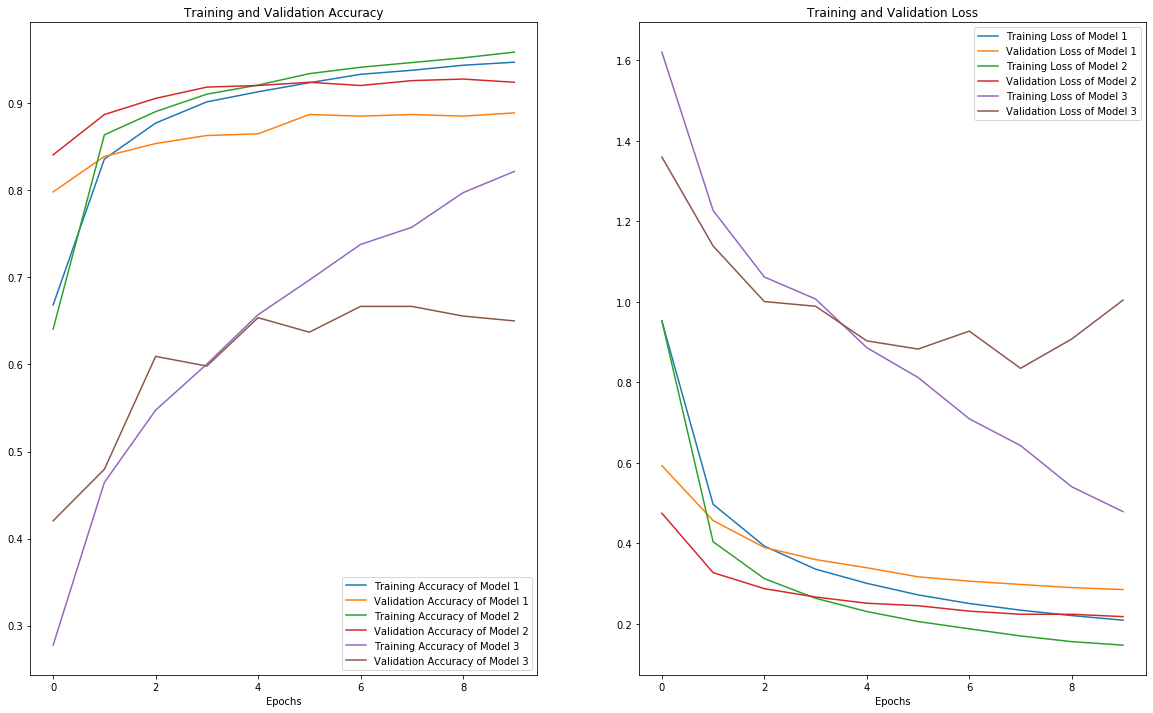

In [0]:
acc1 = history1.history["accuracy"]
val_acc1 = history1.history["val_accuracy"]

acc2 = history2.history["accuracy"]
val_acc2 = history2.history["val_accuracy"]

acc3 = history3.history["accuracy"]
val_acc3 = history3.history["val_accuracy"]

loss1 = history1.history["loss"]
val_loss1  = history1.history["val_loss"]

loss2 = history2.history["loss"]
val_loss2 = history2.history["val_loss"]

loss3 = history3.history["loss"]
val_loss3 = history3.history["val_loss"]

epochs_range = range(EPOCHS)
                     
plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, label="Training Accuracy of Model 1")
plt.plot(epochs_range, val_acc1, label="Validation Accuracy of Model 1")
plt.plot(epochs_range, acc2, label="Training Accuracy of Model 2")
plt.plot(epochs_range, val_acc2, label="Validation Accuracy of Model 2")
plt.plot(epochs_range, acc3, label="Training Accuracy of Model 3")
plt.plot(epochs_range, val_acc3, label="Validation Accuracy of Model 3")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss1, label="Training Loss of Model 1")
plt.plot(epochs_range, val_loss1, label="Validation Loss of Model 1")
plt.plot(epochs_range, loss2, label="Training Loss of Model 2")
plt.plot(epochs_range, val_loss2, label="Validation Loss of Model 2")
plt.plot(epochs_range, loss3, label="Training Loss of Model 3")
plt.plot(epochs_range, val_loss3, label="Validation Loss of Model 3")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.title("Training and Validation Loss")

plt.show()

Use each model to evaluate the testing set and get the loss and accuracy of the models during testing.

In [0]:
test_loss1, test_accuracy1 = model1.evaluate(testing_batches1)
test_loss2, test_accuracy2 = model2.evaluate(testing_batches2)
test_loss3, test_accuracy3 = model3.evaluate(testing_batches1)

1/1 [==============================] - 2s 2s/step - loss: 0.9845 - accuracy: 0.6537


In [0]:
print("Accuracy of model 1 on testing set: ", format(test_accuracy1))
print("Accuracy of model 2 on testing set: ", format(test_accuracy2))
print("Accuracy of model 3 on testing set: ", format(test_accuracy3))

Accuracy of model 1 on testing set:  0.9018518328666687
Accuracy of model 2 on testing set:  0.9037036895751953
Accuracy of model 3 on testing set:  0.6537036895751953


Plot the accuracy of each model on the testing set to compare.

Text(0.5, 1.0, 'Accuracy of Models on Test Set')

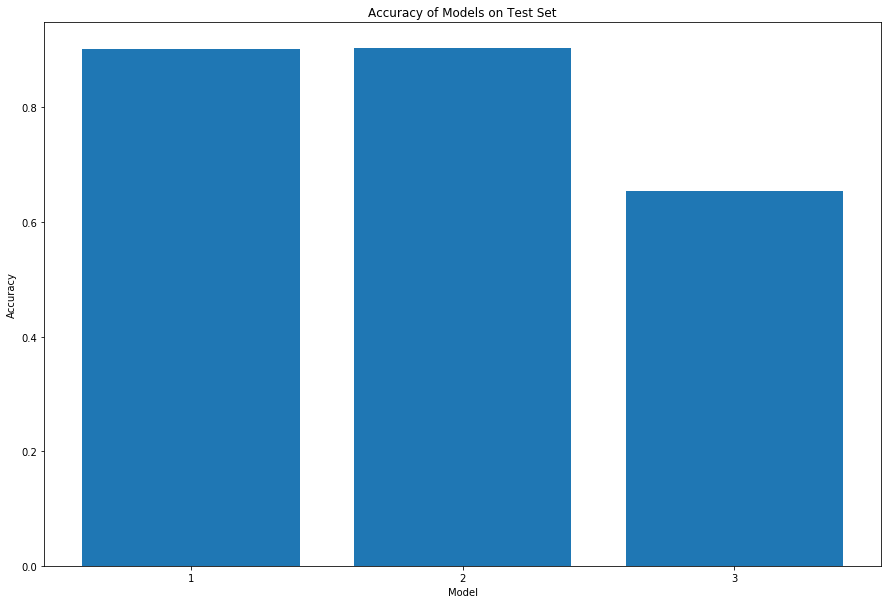

In [0]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 1, 1)
plt.bar(["1", "2", "3"], [test_accuracy1, test_accuracy2, test_accuracy3])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy of Models on Test Set")

Use model one to predict the labels in the testing set.

In [0]:
for test_images, test_labels in testing_batches1.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model1.predict(test_images)

Use model two to predict the labels in the testing set.

In [0]:
for test_images2, test_labels2 in testing_batches2.take(1):
  test_images2 = test_images2.numpy()
  test_labels2 = test_labels2.numpy()
  predictions2 = model2.predict(test_images2)

Use model three to predict the labels in the testing set.

In [0]:
for test_images3, test_labels3 in testing_batches1.take(1):
  test_images3 = test_images3.numpy()
  test_labels3 = test_labels3.numpy()
  predictions3 = model3.predict(test_images3)

Use the predictions of each model and assign the predicted values into a list.

In [0]:
predicted_set = []
for pred in predictions:
  predicted_set.append(np.argmax(pred))

In [0]:
predicted_set2 = []
for pred in predictions2:
  predicted_set2.append(np.argmax(pred))

In [0]:
predicted_set3 = []
for pred in predictions3:
  predicted_set3.append(np.argmax(pred))

Grab a single image.

In [0]:
img = np.array([test_images[0]])

Take the predictions of each model on the image and find the actual label of the image.

In [0]:
single_prediction = model1.predict(img)
predicted_val = np.argmax(single_prediction[0])

single_prediction2 = model2.predict(img)
predicted_val2 = np.argmax(single_prediction2[0])

single_prediction3 = model3.predict(img)
predicted_val3 = np.argmax(single_prediction3[0])

actual_val = test_labels[0]

Plot the image and label the plot with the corresponding prediction each model made.

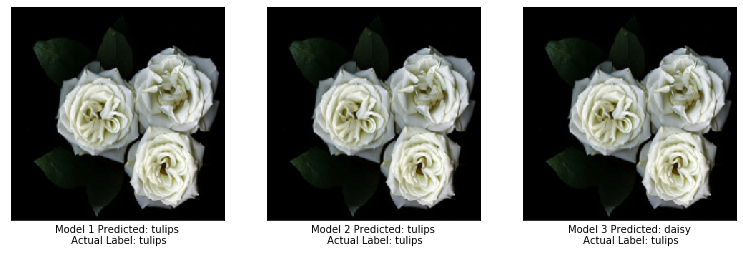

In [0]:
plt.figure(figsize=(13,13))
plt.subplot(1,3,1)
plt.xticks([])
plt.yticks([])
plt.xlabel("Model 1 Predicted: {}\n Actual Label: {}".format(class_labels[predicted_val], class_labels[actual_val]))
plt.imshow(img[0])

plt.subplot(1,3,2)
plt.xticks([])
plt.yticks([])
plt.xlabel("Model 2 Predicted: {}\n Actual Label: {}".format(class_labels[predicted_val2], class_labels[actual_val]))
plt.imshow(img[0])

plt.subplot(1,3,3)
plt.xticks([])
plt.yticks([])
plt.xlabel("Model 3 Predicted: {}\n Actual Label: {}".format(class_labels[predicted_val3], class_labels[actual_val]))
plt.imshow(img[0])

Compare the predictions of each model with the actual values of the test set and get the precisions, recalls, and f1-scores of each prediction set.

In [0]:
precisions, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predicted_set)
precisions2, recall2, f1_score2, _ = precision_recall_fscore_support(test_labels2, predicted_set2)
precisions3, recall3, f1_score3, _ = precision_recall_fscore_support(test_labels3, predicted_set3)

Plot the precision of each model on the same graph to compare.
Plot the recalls and f1-scores in the same manner.

Text(0.5, 1.0, 'f1 Score of Model 1')

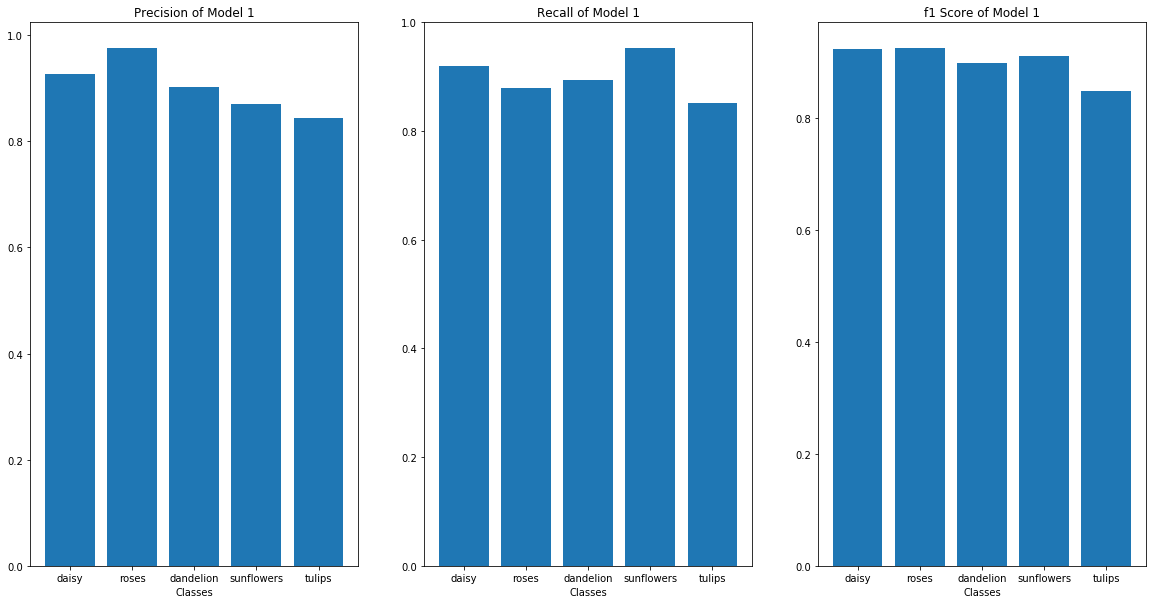

In [0]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.bar(class_labels, precisions)
plt.xlabel('Classes')
plt.title('Precision of Model 1')
plt.subplot(1, 3, 2)
plt.bar(class_labels, recall)
plt.xlabel('Classes')
plt.title('Recall of Model 1')
plt.subplot(1, 3, 3)
plt.bar(class_labels, f1_score)
plt.xlabel('Classes')
plt.title('f1 Score of Model 1')

Text(0.5, 1.0, 'f1 Score of Model 2')

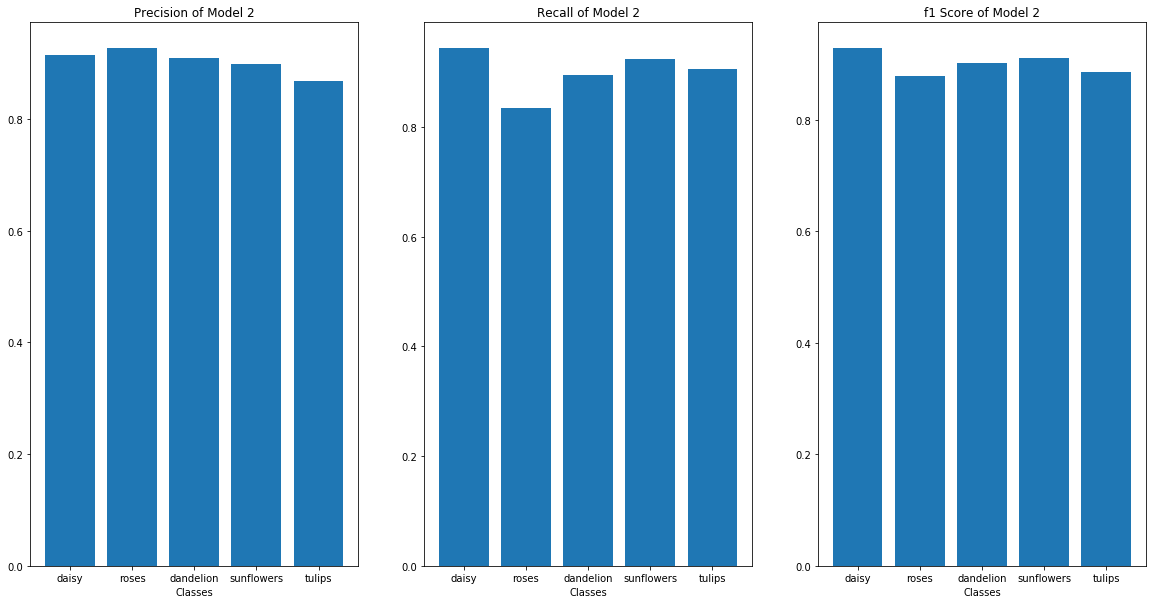

In [0]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.bar(class_labels, precisions2)
plt.xlabel('Classes')
plt.title('Precision of Model 2')
plt.subplot(1, 3, 2)
plt.bar(class_labels, recall2)
plt.xlabel('Classes')
plt.title('Recall of Model 2')
plt.subplot(1, 3, 3)
plt.bar(class_labels, f1_score2)
plt.xlabel('Classes')
plt.title('f1 Score of Model 2')

Text(0.5, 1.0, 'f1 Score of Model 3')

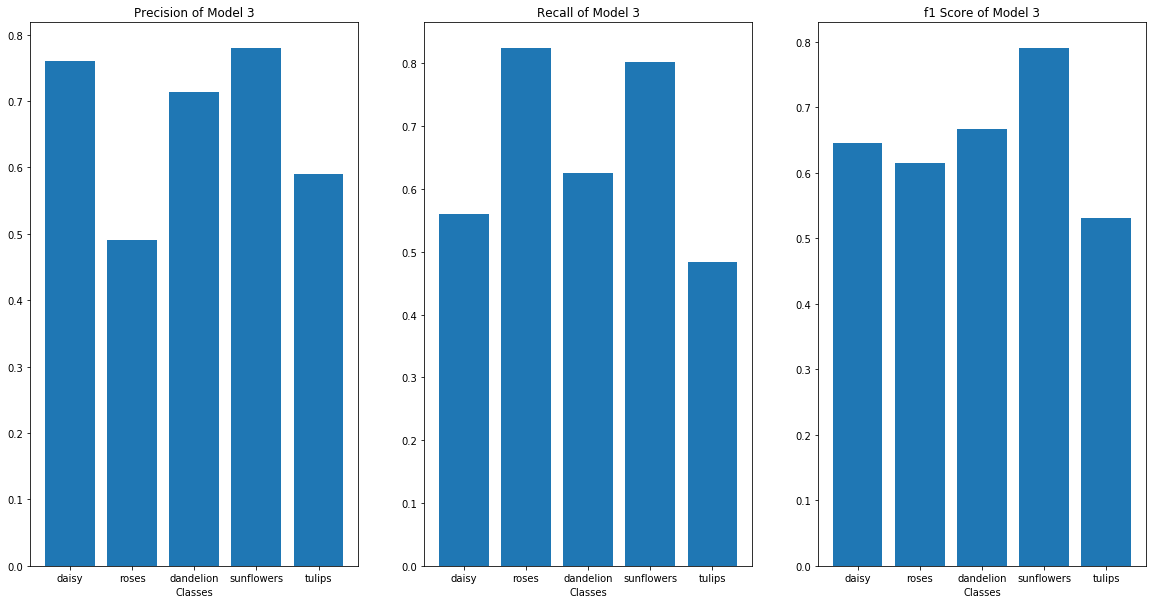

In [0]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.bar(class_labels, precisions3)
plt.xlabel('Classes')
plt.title('Precision of Model 3')
plt.subplot(1, 3, 2)
plt.bar(class_labels, recall3)
plt.xlabel('Classes')
plt.title('Recall of Model 3')
plt.subplot(1, 3, 3)
plt.bar(class_labels, f1_score3)
plt.xlabel('Classes')
plt.title('f1 Score of Model 3')